In [ ]:
import sys
sys.path

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split


In [52]:
train_df = pd.read_csv('./data/train.csv')
test_df = pd.read_csv('./data/test.csv')    
all_df = [train_df, test_df]
train_df.sample(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
558,559,1,1,"Taussig, Mrs. Emil (Tillie Mandelbaum)",female,39.0,1,1,110413,79.6500,E67,S
297,298,0,1,"Allison, Miss. Helen Loraine",female,2.0,1,2,113781,151.5500,C22 C26,S
879,880,1,1,"Potter, Mrs. Thomas Jr (Lily Alexenia Wilson)",female,56.0,0,1,11767,83.1583,C50,C
300,301,1,3,"Kelly, Miss. Anna Katherine ""Annie Kate""",female,NaN,0,0,9234,7.7500,NaN,Q
161,162,1,2,"Watt, Mrs. James (Elizabeth ""Bessie"" Inglis Mi...",female,40.0,0,0,C.A. 33595,15.7500,NaN,S
60,61,0,3,"Sirayanian, Mr. Orsen",male,22.0,0,0,2669,7.2292,NaN,C
83,84,0,1,"Carrau, Mr. Francisco M",male,28.0,0,0,113059,47.1000,NaN,S
152,153,0,3,"Meo, Mr. Alfonzo",male,55.5,0,0,A.5. 11206,8.0500,NaN,S
743,744,0,3,"McNamee, Mr. Neal",male,24.0,1,0,376566,16.1000,NaN,S
492,493,0,1,"Molson, Mr. Harry Markland",male,55.0,0,0,113787,30.5000,C30,S


# 1. Analyze by describing data & Decision

### Which features are available in the dataset?

In [11]:
print(train_df.columns.values)

['PassengerId' 'Survived' 'Pclass' 'Name' 'Sex' 'Age' 'SibSp' 'Parch'
 'Ticket' 'Fare' 'Cabin' 'Embarked']


### Which features are categorical? (nominal, ordinal, ratio, interval)
- Categorical: Survived, Sex, and Embarked 
- Ordinal: Pclass

### Which features are numerical? (continuous, discrete, timeseries)
- Continous: Age, Fare
- Discrete: SibSp, Parch

In [12]:
train_df.info()
print('-'*40)
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null

### Which features are mixed data types?
- Ticket: numeric and alphanumeric
- Cabin: alphanumeric

### Which features may contain errors or typos?
- Name: including titles, round brackets, quotes, alternative or short names

### Which features contain blank, null or empty values?
- Train: Cabin, Age, Embarked
- Test: Cabin, Age, Fare

In [13]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


### What is the distribution of categorical features?
- Name: unique (count=unique=891)
- Sex: 2 (65% male, top=male, freq=577/count=891).
- Cabin: several dupicates (several passengers shared a cabin)
- Embarked: 3 (S port used by most passengers, top=S)
- Ticket: 22% of duplicate values (unique=681)

In [14]:
train_df.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Panula, Master. Urho Abraham",male,347082,B96 B98,S
freq,1,577,7,4,644


### Decision
- 1-hot encoding: Sex [0,1], ***Embarked [0,1,2]**, Pclass[0,1,2], 
- need categorical bound: ***Age**, SibSp, Parch
- need normalize: ***Fare**
- need more analysis: Name, ***Cabin**, Ticket
- *: need null correcting 

In [27]:
train_df['Sex'].unique()

array(['male', 'female'], dtype=object)

In [28]:
# 1-hot encoding
for df in all_df:
    df['Sex'] = df['Sex'].map( {'female': 1, 'male': 0} ).astype(int)
train_df.sample(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
539,540,1,1,"Frolicher, Miss. Hedwig Margaritha",1,22.0,0,2,13568,49.5000,B39,C
380,381,1,1,"Bidois, Miss. Rosalie",1,42.0,0,0,PC 17757,227.5250,NaN,C
128,129,1,3,"Peter, Miss. Anna",1,NaN,1,1,2668,22.3583,F E69,C
347,348,1,3,"Davison, Mrs. Thomas Henry (Mary E Finck)",1,NaN,1,0,386525,16.1000,NaN,S
751,752,1,3,"Moor, Master. Meier",0,6.0,0,1,392096,12.4750,E121,S


# 2. Correlations by pivoting features

- Pclass

In [39]:
train_df[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


- Embarked

In [54]:
train_df[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.336957


- Sex

In [30]:
train_df[["Sex", "Survived"]].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Sex,Survived
1,1,0.742038
0,0,0.188908


- SibSp

In [31]:
train_df[["SibSp", "Survived"]].groupby(['SibSp'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,SibSp,Survived
1,1,0.535885
2,2,0.464286
0,0,0.345395
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


- Parch

In [32]:
train_df[["Parch", "Survived"]].groupby(['Parch'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Parch,Survived
3,3,0.600000
1,1,0.550847
2,2,0.500000
0,0,0.343658
5,5,0.200000
4,4,0.000000
6,6,0.000000


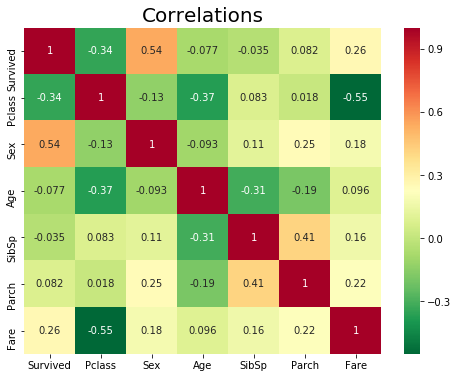

In [41]:
plt.rcParams['figure.figsize'] = [8,6]

drop_list = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'Embarked']
clean_train_df = train_df.drop(drop_list, axis=1)

corr = clean_train_df.corr()
sns.heatmap(corr, cmap='RdYlGn_r', annot=True)#, mask=clean_train_df.isnull())
plt.title('Correlations', fontsize=20)
#plt.show()

# sns.heatmap top and bottom boxes are cut off
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.show() 

# 3. Analyze by visualizing data

### Correlating numerical features
#### Age
- 어떤 age 분포에서 클래스에 대해 가장 큰 차이를 보이는지
- (Age<=16) high survive 
- (16<Age<=32) high died

#### Decision
- Age in our model training
- Complete null values
- band age groups

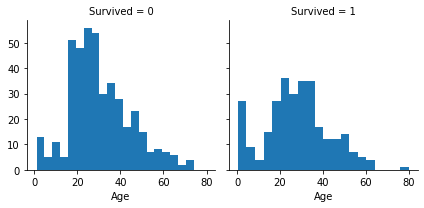

In [44]:
g = sns.FacetGrid(train_df, col='Survived')
g.map(plt.hist, 'Age', bins=20)

### Correlating numerical and ordinal features
#### Pclass & Age
- Most Pclass=3 did not survive
- Most Pclass=1 survived

#### Decision
- Pclass for model training

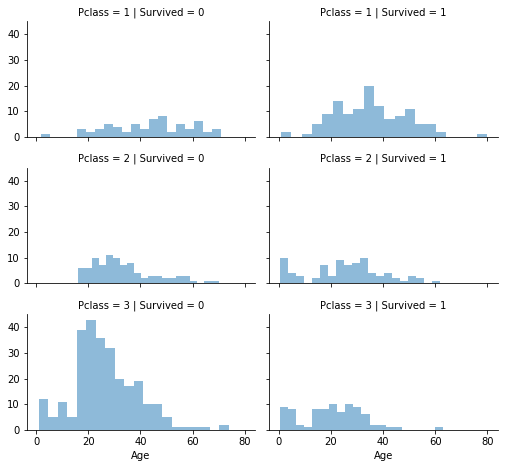

In [50]:
grid = sns.FacetGrid(train_df, col='Survived', row='Pclass', size=2.2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend();

### Correlating categorical features
#### Embarked - Pclass - Sex
- Exception in Embarked=C where males had higher survival rate.
- Males had better survival in Pclass=3 when compared with Pclass=2 for C and Q ports. &rarr; complete에 도움

#### Decisions
- Complete and add Embarked feature to model training.

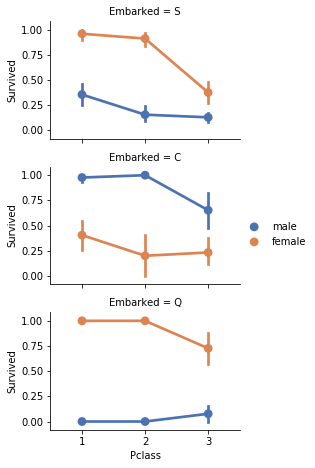

In [53]:
grid = sns.FacetGrid(train_df, row='Embarked', size=2.2, aspect=1.6)
grid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette='deep')
grid.add_legend()

### Correlating categorical and numerical features
#### Embarked - Sex - Fare
- Higher fare paying passengers had better survival. &rarr; fare range?

#### Decisions
- Banding Fare feature.

/home/yksi/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


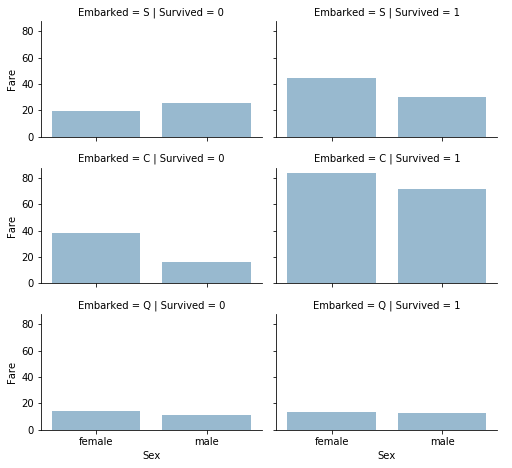

In [55]:
grid = sns.FacetGrid(train_df, row='Embarked', col='Survived', size=2.2, aspect=1.6)
grid.map(sns.barplot, 'Sex', 'Fare', alpha=.5, ci=None)
grid.add_legend()

# 4. Wrangle data
### Dropping features 후보
- Ticket
- Cabin?? Name??은 좀더 생각해보자

### 1) Cabin

In [61]:
# Cabin이 (있다/ 없다) 로 수정
train_df['binary_Cabin'] = [0 if pd.isnull(x) else 1 for x in train_df['Cabin']]
train_df[['binary_Cabin', 'Survived']].groupby(['binary_Cabin'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,binary_Cabin,Survived
1,1,0.666667
0,0,0.299854


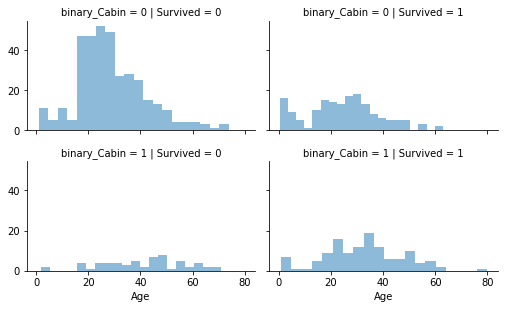

In [82]:
# cabin과 Survived의 관계
grid = sns.FacetGrid(train_df, row='binary_Cabin', col='Survived', size=2.2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend()

### Decision
- Cabin이 있으면 대부분 산다. &rarr; Cabin은 binary로 train model에 포함
- Cabin이 없는 20-40대는 대다수가 죽었다.

### 2) Name 

In [83]:
for df in all_df:
    df['Title'] = df.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
pd.crosstab(train_df['Title'], train_df['Sex'])

Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


In [84]:
for df in all_df:
    df['Title'] = df['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    df['Title'] = df['Title'].replace('Mlle', 'Miss')
    df['Title'] = df['Title'].replace('Ms', 'Miss')
    df['Title'] = df['Title'].replace('Mme', 'Mrs')
    
train_df[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()

,Title,Survived
0,Master,0.575000
1,Miss,0.702703
2,Mr,0.156673
3,Mrs,0.793651
4,Rare,0.347826


### Decision
- Creating new feature extracting from existing: Name &rarr; Title

In [85]:
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
for df in all_df:
    df['Title'] = df['Title'].map(title_mapping)
    df['Title'] = df['Title'].fillna(0) # fill NaN -> 0
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,binary_Cabin,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1,3
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1,3
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0,1


### 3) Age

In [86]:
train_df['Sex'].unique()

array(['male', 'female'], dtype=object)

In [87]:
for df in all_df:
    df['Sex'] = df['Sex'].map( {'female': 1, 'male': 0} ).astype(int)
train_df.sample(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,binary_Cabin,Title
851,852,0,3,"Svensson, Mr. Johan",0,74.0,0,0,347060,7.775,NaN,S,0,1
216,217,1,3,"Honkanen, Miss. Eliina",1,27.0,0,0,STON/O2. 3101283,7.925,NaN,S,0,2
351,352,0,1,"Williams-Lambert, Mr. Fletcher Fellows",0,NaN,0,0,113510,35.000,C128,S,1,1
504,505,1,1,"Maioni, Miss. Roberta",1,16.0,0,0,110152,86.500,B79,S,1,2
301,302,1,3,"McCoy, Mr. Bernard",0,NaN,2,0,367226,23.250,NaN,Q,0,1
